                                         .-.-.  .-.-.  .-.-.  .-.-.  .-.-.  .-.-.  .-.-.  .-.-.  .-.-.  .-.-.  .-.-.  .-.-. 
                                        ( E .' ( n .' ( g .' ( a .' ( g .' ( e .' ( m .' ( e .' ( n .' ( t .' ( A .' ( I .'
                                         `.(    `.(    `.(    `.(    `.(    `.(    `.(    `.(    `.(    `.(    `.(    `.(

In [80]:
%reset -f

In [81]:
photo = r'..\db\input\images\frame33.jpg'
outputjson_emotion = r'..\db\input\json\frame33.json' # Output is retrived from Amazon Rekognition services

In [82]:
# Import dependencies
from PIL import Image
import pandas as pd
import numpy as np
import cv2
import json
import random
import matplotlib.pyplot as plt

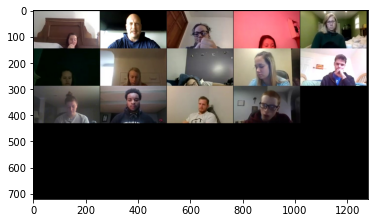

In [83]:
# Import sample images
img0=np.array(Image.open(photo))
plt.imshow(img0)
plt.show()

In [85]:
# Read output json
coordinates_emotions=json.load(open(outputjson_emotion,"r"))

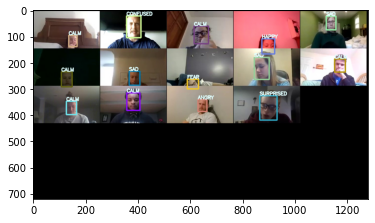

In [79]:
# Inferences
result = img0.copy()
for i,value in enumerate(coordinates_emotions["FaceDetails"]):
    BoundingBox = value["BoundingBox"]
    df=pd.DataFrame(value["Emotions"])
    emotions=dict(zip(list(df["Type"]),list(df["Confidence"])))
    # emotions["Person"]="Ashish"
    label='%s' % (df["Type"].iloc[df['Confidence'].idxmax()])
    tl = round(0.002 * (img0.shape[0] + img0.shape[1]) / 2) + 1  # line/font thickness
    color = [random.randint(0, 255) for _ in range(3)]
    tf = max(tl - 1, 1)  # font thickness
    t_size = cv2.getTextSize(label, 0, fontScale=tl / 3, thickness=tf)[0]
    x1, y1, w_size, h_size= BoundingBox["Left"], BoundingBox["Top"], BoundingBox["Width"],BoundingBox["Height"]
    x_start = round(x1*img0.shape[1])
    y_start = round(y1*img0.shape[0])
    x_end = round(x_start + w_size*img0.shape[1])
    y_end = round(y_start + h_size*img0.shape[0])
    roi=img0.copy()
    roi = roi[y_start:y_end, x_start:x_end]
    cv2.imwrite(rf"..\db\artifact\Person_{str(i)}.jpg",cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
    c1,c2=(x_start, y_start), (x_end, y_end)
    cv2.rectangle(result, c1,c2,color, thickness=tl, lineType=cv2.LINE_AA) 
    cv2.putText(result, label, (c1[0], c1[1] - 2), 0, tl / 5, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)
cv2.imwrite(r"..\out\result1.jpg",cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.imshow(result)
plt.show()

# Analysis of one image

In [14]:
%reset -f

In [15]:
import os
import glob
import json
import cv2
import random
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image

path = r"C:\Users\imash\Documents\upwork" # This need to modify as per your parent folder of this project

photo = path+'/db/input/images/frame33.jpg' # Selected image for analysis
outputjson_emotion = path+'/db/input/json/frame33.json'
Marks=pd.read_csv(path + "/db/input/docs/Marks.csv")
QnA=pd.read_csv(path + "/db/input/docs/QnA.csv")
img0=np.array(Image.open(photo))
coordinates_emotions=json.load(open(outputjson_emotion,"r"))

ArtifactFiles = glob.glob(path+ "/db/artifact/Person_*.jpg") # get all the file name with directory ends with *.jpg
PersonName = list(map(lambda x: os.path.split(x)[1].split(".")[0],ArtifactFiles)) # To get the name of the persons

In [16]:
def similarity(image_one, image_two):
    """ To find the cosine siilarity between two images """
    # data1 image
    gray_image1 = cv2.cvtColor(cv2.resize(cv2.imread(image_one), (300, 300)), cv2.COLOR_BGR2GRAY) # Read from disk
    # data2 image
    gray_image2 = cv2.cvtColor(cv2.resize(image_two, (300, 300)), cv2.COLOR_BGR2GRAY) # Read from matrics 
    # Cosine similarity
    similarity = cosine_similarity(gray_image1.reshape(1,-1),gray_image2.reshape(1,-1))[0][0]
    # print(f"[info...] Similarity = {similarity}")
    return(similarity)
algo = lambda x: 0.8*(x["CALM"]+x["HAPPY"])-0.1*(x["SURPRISED"]+x["CONFUSED"]+x["ANGRY"]+x["SAD"]+x["DISGUSTED"]+x["FEAR"])+0.2*(x["Marks Obtained"]+0.1*x["Question Asked"])

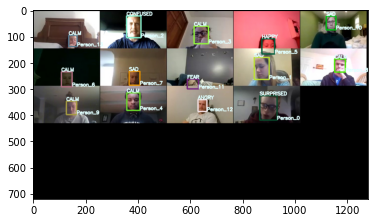

In [17]:
# Inferences
result = img0.copy()
data = []
for i,value in enumerate(coordinates_emotions["FaceDetails"]):
    BoundingBox = value["BoundingBox"]
    df=pd.DataFrame(value["Emotions"])
    output=dict(zip(list(df["Type"]),list(df["Confidence"])))
    label='%s' % (df["Type"].iloc[df['Confidence'].idxmax()])
    x1, y1, w_size, h_size= BoundingBox["Left"], BoundingBox["Top"], BoundingBox["Width"],BoundingBox["Height"]
    x_start = round(x1*img0.shape[1])
    y_start = round(y1*img0.shape[0])
    x_end = round(x_start + w_size*img0.shape[1])
    y_end = round(y_start + h_size*img0.shape[0])
    roi=img0.copy()
    similarity_score = [similarity(file, cv2.cvtColor(roi[y_start:y_end, x_start:x_end], cv2.COLOR_BGR2RGB)) for file in ArtifactFiles]

    if max(similarity_score) >= 0.95:
        output["Person"]=PersonName[similarity_score.index(max(similarity_score))]
        output["Marks Obtained"] = list(Marks[Marks["Person"]==output["Person"]]["Percentage"])[0]
        output["Question Asked"] = list(QnA[QnA["Person"]==output["Person"]]["Asked Question"])[0]
        output["Image Link"] = f"https://rekoengagementai.s3.amazonaws.com/artifact/{PersonName[similarity_score.index(max(similarity_score))]}.jpg"
    else:
        output["Person"] = "XXXXX"
        output["Marks Obtained"] = ''
        output["Question Asked"] =''
        output["Image Link"] = ''

    del similarity_score

    data.append(output)

    label='%s' % (df["Type"].iloc[df['Confidence'].idxmax()])
    tl = round(0.002 * (img0.shape[0] + img0.shape[1]) / 2) + 1  # line/font thickness
    color = [random.randint(0, 255) for _ in range(3)]
    tf = max(tl - 1, 1)  # font thickness
    t_size = cv2.getTextSize(label, 0, fontScale=tl / 3, thickness=tf)[0]
    c1,c2=(x_start, y_start), (x_end, y_end)
    cv2.rectangle(result, c1,c2,color, thickness=tl, lineType=cv2.LINE_AA) 
    cv2.putText(result, label, (c1[0], c1[1] - 2), 0, tl / 5, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)
    cv2.putText(result, output["Person"], (c2[0], c2[1] - 2), 0, tl / 5, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)
cv2.imwrite(r"output.jpg",cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.imshow(result)
plt.show()   


In [18]:
Result= pd.DataFrame(data)

In [19]:
Result["AI Engagement Score"] = Result.apply(algo,axis=1)
Result["AI raw data"] = str(coordinates_emotions)

In [22]:
Result.to_excel("analysis.xlsx")

# Calculation of combined excel

In [23]:
%reset -f

In [25]:
import pandas as pd
df=pd.read_excel("../FinalAnalysisReport.xlsx")

In [27]:
df.head(2)

,CALM,CONFUSED,SAD,SURPRISED,ANGRY,HAPPY,FEAR,DISGUSTED,FileName,Person,Marks Obtained,Question Asked,Image Link,AI Engagement Score,AI raw data
0,89.869171,4.061630,1.872306,1.723629,1.510588,0.582357,0.194547,0.185770,c:/Users/imash/Documents/upwork/db/input/video...,Person_7,0,0,https://rekoengagementai.s3.amazonaws.com/arti...,71.406375,{'FaceDetails': [{'BoundingBox': {'Width': 0.0...
1,4.692371,1.726817,3.501806,4.684594,33.610291,5.539573,44.918583,1.325971,c:/Users/imash/Documents/upwork/db/input/video...,Person_2,0,0,https://rekoengagementai.s3.amazonaws.com/arti...,-0.791250,{'FaceDetails': [{'BoundingBox': {'Width': 0.0...


In [33]:
pd.DataFrame(df.groupby('Person')['AI Engagement Score'].mean()).reset_index(drop=False)

,Person,AI Engagement Score
0,Person_0,-7.214904
1,Person_1,23.708194
2,Person_10,12.012432
3,Person_11,28.658491
4,Person_12,27.621204
5,Person_13,56.493218
6,Person_2,1.314139
7,Person_3,24.279188
8,Person_4,59.552423
9,Person_5,45.463538
